In [1]:
import os
import shap
import getpass
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from datetime import timedelta, datetime
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras import backend as K, losses, optimizers, layers, models, utils, callbacks


/Users/owenclary/.pyenv/versions/3.10.6/envs/x_ray_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Make sure to update the paths in this notebook
This cell below and one of the last cells in Save Preformance needs your local path to your data

## Load Data 🩻

In [2]:
# Update this path
data_dir = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification"

# Load the train data
train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)
[]
# Load the test data
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 9391 files belonging to 11 classes.
Using 8452 files for training.
Found 9391 files belonging to 11 classes.
Using 939 files for validation.


## Prepresses Data 🔧

In [3]:
# Inspect class names
class_names = train_data.class_names
print("Class names: ", class_names)
print("Num Classes: ", len(class_names))

Class names:  ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture', 'non_fractured']
Num Classes:  11


In [4]:
# Data preprocessing
def preprocess(img):
    img = tf.cast(img, "float32") / 256
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [5]:
# Get train data and labels
x_train = []
y_train = []

for images, labels in train_dataset:
    # Append train data to x_train
    x_train.append(images.numpy())

    # Append labels to y_train
    y_train.append(labels.numpy())

# Concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

2024-06-07 09:46:46.264813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# Get val data and labels
x_val = []
y_val = []

for images, labels in val_dataset:
    # Append train data to x_train
    x_val.append(images.numpy())

    # Append labels to y_train
    y_val.append(labels.numpy())

# Concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

2024-06-07 09:47:04.165828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# One-hot encode the train, val data
NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

In [8]:
x_train.shape

(8452, 256, 256, 3)

## Initialize Model 🤌



In [27]:
def initialize_model(x_train):
    '''
    base_model = EfficientNetB0(include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), weights='imagenet')

    base_model.trainable = False

    model = models.Sequential()
    model.add(base_model)

    model.add(layers.GlobalAveragePooling2D())
    #model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dense(units=10))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
   # model.add(layers.Dropout(rate=0.2))

    # Adjust the final layer to match the number of classes
    model.add(layers.Dense(units=NUM_CLASSES, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    model.summary()

    return model
    '''
    model = models.Sequential()

    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding="same", input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Conv2D(64, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Conv2D(128, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Conv2D(256, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=100))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Dense(units=11, activation="softmax"))

    opt = optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    model.summary()

    return model

NUM_CLASSES = len(class_names)
model = initialize_model(x_train)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)      │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)      │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128, 128, 32)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_10 (Dropout)            │ (None, 128, 128, 32)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64, 64, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_11 (Dropout)            │ (None, 64, 64, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)       │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 32, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)       │      1,024 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 256)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 256)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 100)               │  6,553,700 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_14          │ (None, 100)               │        400 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 100)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_14 (Dropout)            │ (None, 100)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 11)                │      1,111 │
└─────────────────────────────────┴───────────────────────────┴──────────

 Total params: 6,945,547 (26.50 MB)

 Trainable params: 6,944,387 (26.49 MB)

 Non-trainable params: 1,160 (4.53 KB)

## Train the Model 💪 

In [10]:
# Save checkpoints to monitor best performing models
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/best_model.weights.h5",
    save_weights_only=True,  # Save only the weights
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

tensorboard_callback = callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)

In [13]:
# Start timer
start_train_time = datetime.now()

epochs = 10
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.3,
    callbacks=[
        early_stopping,
        model_checkpoint_callback,
        tensorboard_callback,
    ]
)

# End timer
end_train_time = datetime.now()
train_time = (end_train_time - start_train_time).total_seconds()

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.1041 - loss: 2.8091
Epoch 1: val_loss improved from inf to 2.98002, saving model to ./checkpoint/best_model.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 88s 468ms/step - accuracy: 0.1042 - loss: 2.8082 - val_accuracy: 0.1124 - val_loss: 2.9800
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1634 - loss: 2.3527
Epoch 2: val_loss improved from 2.98002 to 2.31657, saving model to ./checkpoint/best_model.weights.h5
185/185 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.1635 - loss: 2.3526 - val_accuracy: 0.1964 - val_loss: 2.3166
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.1684 - loss: 2.3287
Epoch 3: val_loss did not improve from 2.31657
185/185 ━━━━━━━━━━━━━━━━━━━━ 80s 433ms/step - accuracy: 0.1685 - loss: 2.3286 - val_accuracy: 0.1755 - val_loss: 2.3631
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.1880 - loss: 2.2894
Epoch 4: val_loss did not improve from 2.316

## Evaluate the Model 🕵️‍♂️

In [14]:
# Get Loss and Accuracy metrics
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["accuracy"]

print('Train Loss: ', train_loss)
print('Train Accuracy: ', train_accuracy)
print('Val Loss: ', val_loss)
print('Val Accuracy: ', val_accuracy)

Train Loss:  [2.642695188522339, 2.341454267501831, 2.303255558013916, 2.2814266681671143, 2.2740695476531982, 2.264971971511841, 2.254417896270752, 2.2361974716186523, 2.215106248855591, 2.2054245471954346]
Train Accuracy:  [0.12068965286016464, 0.16632859408855438, 0.1783299595117569, 0.18864096701145172, 0.18881000578403473, 0.19066937267780304, 0.1984448879957199, 0.20030425488948822, 0.21264368295669556, 0.21467207372188568]
Val Loss:  [2.9800171852111816, 2.316566228866577, 2.3630690574645996, 2.50251841545105, 2.2858598232269287, 2.298281192779541, 2.2542710304260254, 2.2223241329193115, 2.3369903564453125, 2.2002875804901123]
Val Accuracy:  [0.12068965286016464, 0.16632859408855438, 0.1783299595117569, 0.18864096701145172, 0.18881000578403473, 0.19066937267780304, 0.1984448879957199, 0.20030425488948822, 0.21264368295669556, 0.21467207372188568]


In [15]:
# Start timer
start_eval_time = datetime.now()

# Evaluate model
model.evaluate(x_val, y_val)

# End timer
end_eval_time = datetime.now()
eval_time = (end_eval_time - start_eval_time).total_seconds()

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.2215 - loss: 2.1712


## Plote Learning Curve 📊

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

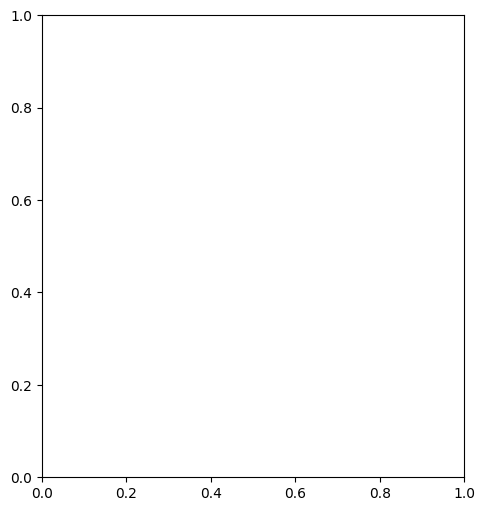

In [16]:
# Plot learning curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Calculate Preformance 🔍

In [17]:
# Start prediction timer
start_pred_time = datetime.now()

# Get predictions of the model
preds = model.predict(x_val)
CLASSES = np.array(class_names)
predictions = CLASSES[np.argmax(preds, axis=-1)]
y_val_classes = CLASSES[np.argmax(y_val, axis=-1)]

# Ender prediction timer
end_pred_time = datetime.now()
pred_time = (end_pred_time - start_pred_time).total_seconds()

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


In [18]:
# Calculate accuracy, precision, recall, f1
accuracy = accuracy_score(predictions, y_val_classes)
precision = precision_score(predictions, y_val_classes, average='weighted')
recall = recall_score(predictions, y_val_classes, average='weighted')
f1 = f1_score(predictions, y_val_classes, average='weighted')

# Save the metrics to a file
with open("metrics.txt", "w") as file:
    file.write(f"{accuracy}\n")
    file.write(f"{precision}\n")
    file.write(f"{recall}\n")
    file.write(f"{f1}\n")

# Optionally, print the metrics for quick reference
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.21192758253461128
Precision: 0.31416531967713657
Recall: 0.21192758253461128
F1 Score: 0.2435992100880212


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


## Save Preformance to CSV 📝

In [19]:
def log_model_metrics(metrics_file, csv_file, model_name, train_time, eval_time, pred_one_time):

    # Load metrics generated by train_eval.py
    metrics_df = pd.read_csv(metrics_file, header=None, names=["value"])
    accuracy = float(metrics_df.iloc[0].value)
    precision = float(metrics_df.iloc[1].value)
    recall = float(metrics_df.iloc[2].value)
    f1 = float(metrics_df.iloc[3].value)

    # Log results to DataFrame
    columns = ["name", "model", "train_time", "test_time", "pred_one_time", "accuracy", "precision", "recall", "f1"]
    name = getpass.getuser()  # Get the username of the person running the script

    # Create a DataFrame to hold the new data
    data = {
        "name": [name],
        "model": [model_name],
        "train_time": [train_time],
        "eval_time": [eval_time],
        "pred_one_time": [pred_one_time],
        "accuracy": [accuracy],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1]
    }
    df_new = pd.DataFrame(data)

    # Check if the file exists
    if os.path.exists(csv_file):
        # If the file exists, append the new data
        df_existing = pd.read_csv(csv_file)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        # If the file does not exist, the new data is the combined data
        df_combined = df_new

    # Save the combined data to the CSV file
    df_combined.to_csv(csv_file, index=False)


In [20]:
def preprocess_single_image(img_path, target_size=(256, 256)):
    """
    Load and preprocess a single image
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize if needed
    return img_array

In [21]:
def predict_single_image(model, img_array, class_names_dict):
    """
    Make a prediction on a single image
    """
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=-1)
    class_name = class_names_dict[predicted_class[0]]
    return class_name


In [22]:
# Update this path to any single image
img_path = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification/Avulsion fracture/Train/94f6a-pclavulsion1a_png.rf.621b9fb0ecda5666f169e06b88d35b9e.jpg"

# Preprocess a single image
img_array = preprocess_single_image(img_path)

class_names_dict = {
    0: 'Avulsion fracture',
    1: 'Comminuted fracture',
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture',
    10: 'non_fractured'
}

Predict One Image

In [23]:
# Start single image prediction timer
start_pred_one_time = datetime.now()

# Predict one image
predicted_class_name = predict_single_image(model, img_array, class_names_dict)
print("Predicted class:", predicted_class_name)

# End timer
end_pred_one_time = datetime.now()
pred_one_time = (end_pred_one_time - start_pred_one_time).total_seconds()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: Avulsion fracture


In [24]:
# Run log model metrics function
log_model_metrics("metrics.txt", "results.csv", "Original-CNN-Kaggle", train_time, eval_time, pred_one_time)

## Examine Data 📊

In [25]:
# Read the results csv
res = pd.read_csv('/Users/owenclary/code/Owencclary/x_ray_lewagon2024/notebooks/results.csv')

res

,name,model,train_time,eval_time,pred_one_time,accuracy,precision,recall,f1
0,owenclary,Original-CNN-Kaggle,1881.755527,3.204296,0.053049,0.211928,0.314165,0.211928,0.243599


## Shapley  🚀


In [26]:
# Masker that will mask out partitions of the input image with smaller blur
masker = shap.maskers.Image("blur(16, 16)", img_array[0].shape)

# Create the explainer
explainer = shap.Explainer(model, masker, output_names=list(class_names_dict.values()))

# Explain the single image to estimate SHAP values
shap_values = explainer(img_array, max_evals=8000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])  # Increased max_evals

# Show the plot
shap.image_plot(shap_values, pixel_values=img_array)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations